# Preprocessing danych

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_frame = pd.read_csv('../Data/Raw_data_2023.csv', encoding='unicode_escape', sep=",")
data_frame.dtypes

Month                               object
Day                                  int64
Week day                            object
Hour                                 int64
Dry-Bulb Temp (°C)                 float64
Heating Load (kW)                  float64
Chiller Output (kW)                float64
Chiller Input (kW)                 float64
Total Building Electric [kW]       float64
Precool Coil Load (kW)             float64
Preheat Coil Load (kW)             float64
Terminal Cooling Coil Load (kW)    float64
Terminal Heating Coil Load (kW)    float64
Ventilation Fan (kW)               float64
Exhaust Fan (kW)                   float64
Terminal Fan (kW)                  float64
Vent. Reclaim Device (kW)          float64
Lighting (kW)                      float64
Electric Equipment (kW)            float64
dtype: object

In [3]:
base_df = data_frame[['Hour','Dry-Bulb Temp (°C)']]
base_df

,Hour,Dry-Bulb Temp (°C)
0,0,-4.3
1,1,-4.1
2,2,-4.0
3,3,-3.8
4,4,-3.5
...,...,...
8755,19,0.2
8756,20,0.3
8757,21,0.3
8758,22,0.3


In [4]:
month_df= data_frame['Month'].values
month_df

array(['Jan', 'Jan', 'Jan', ..., 'Dec', 'Dec', 'Dec'], dtype=object)

In [5]:
month_encoded = pd.get_dummies(month_df, columns = ['Month'])
month_encoded

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,False,False,True,False,False,False,False,False,False,False,False,False
8756,False,False,True,False,False,False,False,False,False,False,False,False
8757,False,False,True,False,False,False,False,False,False,False,False,False
8758,False,False,True,False,False,False,False,False,False,False,False,False


In [6]:
weekday_df = data_frame['Week day'].values
weekday_df

array(['Sunday', 'Sunday', 'Sunday', ..., 'Sunday', 'Sunday', 'Sunday'],
      dtype=object)

In [7]:
weekday_encoded = pd.get_dummies(weekday_df, columns = ['Week day'])
weekday_encoded

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False
3,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...
8755,False,False,False,True,False,False,False
8756,False,False,False,True,False,False,False
8757,False,False,False,True,False,False,False
8758,False,False,False,True,False,False,False


In [8]:
X_train = np.concatenate((base_df, month_encoded, weekday_encoded), axis=1)
print(X_train.shape)

(8760, 21)


In [9]:
y_train= data_frame['Total Building Electric [kW]'].values
y_train

array([55.2, 55.2, 55.3, ..., 54.6, 54.6, 54.7])

In [10]:
data_frame_2024 = pd.read_csv('../Data/Raw_data_2024.csv', encoding='unicode_escape', sep=",")
data_frame_2024.dtypes
base_2024_df = data_frame_2024[['Hour','Dry-Bulb Temp (°C)']]
month_2024_df= data_frame_2024['Month'].values
month_2024_encoded = pd.get_dummies(month_2024_df, columns = ['Month'])
weekday_2024_df = data_frame_2024['Week day'].values
weekday_2024_encoded = pd.get_dummies(weekday_2024_df, columns = ['Week day'])
X_test = np.concatenate((base_2024_df, month_2024_encoded, weekday_2024_encoded), axis=1)
y_test = data_frame_2024['Total Building Electric [kW]'].values

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

# Hyperparameters tuning

### Metoda do tworzenia modelu

In [12]:
def create_neural_network(hp):
    model = Sequential()
    model.add(Input(shape= (X_train.shape[1],)))

    for i in range(hp.Int('layers', 1, 4)):
        model.add(Dense(units= hp.Int('layer_'+ str(i+1),
                                  min_value=4,
                                  max_value=64,
                                  step=4),
                        activation='relu'))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(
                      hp.Choice('learning_rate',
                                values=[1e-3, 1e-4])),
                  metrics=['mae'])
    return model

### Non scaled data

In [13]:
tuner_NonScaled_total_building = RandomSearch(
    create_neural_network,
    objective= 'val_mae',
    max_trials=20,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Total_Building_NonScaled_Tuning'
)

In [14]:
tuner_NonScaled_total_building.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [15]:
tuner_NonScaled_total_building.search(X_train, y_train,
             epochs=20,
             validation_data=(X_test, y_test))

Trial 20 Complete [00h 00m 30s]
val_mae: 346.3280843098958

Best val_mae So Far: 104.8079325358073
Total elapsed time: 00h 10m 38s


In [16]:
tuner_NonScaled_total_building.results_summary()

Results summary
Results in my_dir\Total_Building_NonScaled_Tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 13 summary
Hyperparameters:
layers: 4
layer_1: 60
learning_rate: 0.001
layer_2: 4
layer_3: 60
layer_4: 48
Score: 104.8079325358073

Trial 16 summary
Hyperparameters:
layers: 4
layer_1: 24
learning_rate: 0.001
layer_2: 8
layer_3: 28
layer_4: 64
Score: 109.0886942545573

Trial 11 summary
Hyperparameters:
layers: 4
layer_1: 8
learning_rate: 0.001
layer_2: 28
layer_3: 8
layer_4: 28
Score: 117.75384775797527

Trial 03 summary
Hyperparameters:
layers: 4
layer_1: 8
learning_rate: 0.001
layer_2: 44
layer_3: 4
layer_4: 4
Score: 141.91002400716147

Trial 02 summary
Hyperparameters:
layers: 2
layer_1: 64
learning_rate: 0.001
layer_2: 40
Score: 142.37859598795572

Trial 05 summary
Hyperparameters:
layers: 2
layer_1: 36
learning_rate: 0.001
layer_2: 12
layer_3: 44
layer_4: 48
Score: 177.76111348470053

Trial 10 summary
Hyperparameters:
layers: 4
layer_1: 36
lear

### Scaled data

In [17]:
from sklearn.preprocessing import StandardScaler
total_building_scaler = StandardScaler()
X_scaled_train = total_building_scaler.fit_transform(X_train)
X_scaled_test = total_building_scaler.transform(X_test)

In [18]:
tuner_scaled_total_building = RandomSearch(
    create_neural_network,
    objective= 'val_mae',
    max_trials=20,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Total_building_Scaled_Tuning'
)

In [19]:
tuner_scaled_total_building.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [20]:
tuner_scaled_total_building.search(X_scaled_train, y_train,
             epochs=20,
             validation_data=(X_scaled_test, y_test))

Trial 20 Complete [00h 00m 37s]
val_mae: 363.1987609863281

Best val_mae So Far: 105.95751444498698
Total elapsed time: 00h 11m 28s


In [21]:
tuner_scaled_total_building.results_summary()

Results summary
Results in my_dir\Total_building_Scaled_Tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 17 summary
Hyperparameters:
layers: 4
layer_1: 48
learning_rate: 0.001
layer_2: 32
layer_3: 40
layer_4: 60
Score: 105.95751444498698

Trial 01 summary
Hyperparameters:
layers: 3
layer_1: 36
learning_rate: 0.001
layer_2: 48
layer_3: 60
layer_4: 32
Score: 121.56215413411458

Trial 03 summary
Hyperparameters:
layers: 3
layer_1: 48
learning_rate: 0.001
layer_2: 40
layer_3: 36
layer_4: 4
Score: 192.518430074056

Trial 04 summary
Hyperparameters:
layers: 3
layer_1: 36
learning_rate: 0.001
layer_2: 64
layer_3: 8
layer_4: 28
Score: 264.46238708496094

Trial 06 summary
Hyperparameters:
layers: 2
layer_1: 64
learning_rate: 0.001
layer_2: 40
layer_3: 56
layer_4: 8
Score: 293.8821258544922

Trial 12 summary
Hyperparameters:
layers: 1
layer_1: 28
learning_rate: 0.001
layer_2: 24
layer_3: 60
layer_4: 40
Score: 336.2073669433594

Trial 02 summary
Hyperparameters:
lay

# Tworzenie modelu na podstawie najlepszych hiperparametrów

In [22]:
def create_model_from_hyperparameters(params):
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(X_train.shape[1],)))  

    num_layers = params.get('layers', 1)
    for i in range(num_layers):
            model.add(layers.Dense(units = params.get(f'layer_{i}', 32),
                                   activation = params.get(f'act_{i}', 'relu')))
    model.add(layers.Dense(1))

    learning_rate = params.get('learning_rate', 0.01)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

In [23]:
best_nonscaled_hyperparameters = tuner_NonScaled_total_building.get_best_hyperparameters(num_trials=1)[0]
best_nonscaled_model = create_model_from_hyperparameters(best_nonscaled_hyperparameters.values)
best_nonscaled_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 60)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,289 (12.85 KB)

 Trainable params: 3,289 (12.85 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
best_scaled_hyperparameters = tuner_scaled_total_building.get_best_hyperparameters(num_trials=1)[0]
best_scaled_model = create_model_from_hyperparameters(best_scaled_hyperparameters.values)
best_scaled_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 40)             │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,217 (20.38 KB)

 Trainable params: 5,217 (20.38 KB)

 Non-trainable params: 0 (0.00 B)

### Trenowanie modeli na podstawie najlepszych parametrów

#### NonScaled

In [25]:
non_scaled_history = best_nonscaled_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))
non_scaled_mse, non_scaled_mae = best_nonscaled_model.evaluate(X_test, y_test)
print("Non scaled data")
print(f'Mean Squared Error: {non_scaled_mse}, Mean Absolute Error: {non_scaled_mae}')

Epoch 1/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 347216.5938 - mae: 423.0794 - val_loss: 236100.0469 - val_mae: 401.4632
Epoch 2/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 214658.4219 - mae: 364.9158 - val_loss: 174980.9531 - val_mae: 323.4670
Epoch 3/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 142230.8125 - mae: 284.5583 - val_loss: 84612.2578 - val_mae: 202.7534
Epoch 4/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 64089.4805 - mae: 165.5344 - val_loss: 61861.6602 - val_mae: 166.5841
Epoch 5/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 48539.7695 - mae: 138.9571 - val_loss: 47571.7891 - val_mae: 133.7095
Epoch 6/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42273.1680 - mae: 126.5969 - val_loss: 42836.5547 - val_mae: 125.1826
Epoch 7/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42072.8203 - mae: 125.5400 - val_loss: 39775.7305 - val_mae: 118.2699
Epoch 8/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39620.5312 - mae:

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25515.6816 - mae: 90.3862 - val_loss: 26418.1836 - val_mae: 89.0557
Epoch 51/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25507.4121 - mae: 90.1345 - val_loss: 26834.5547 - val_mae: 93.8877
Epoch 52/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26124.7246 - mae: 92.4170 - val_loss: 26429.4707 - val_mae: 91.0895
Epoch 53/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23544.4648 - mae: 87.5372 - val_loss: 26847.9766 - val_mae: 92.9883
Epoch 54/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24962.5723 - mae: 88.9698 - val_loss: 25255.3027 - val_mae: 90.6318
Epoch 55/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25488.6016 - mae: 90.2738 - val_loss: 25070.1797 - val_mae: 90.2083
Epoch 56/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23761.6973 - mae: 88.5300 - val_loss: 26575.9688 - val_mae: 93.7065
Epoch 57/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25132.7148 - mae: 91.2356 - val_loss: 257

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10382.7041 - mae: 53.3947 - val_loss: 14320.4902 - val_mae: 59.1523
Epoch 101/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11335.8691 - mae: 58.6761 - val_loss: 14380.3721 - val_mae: 61.5865
Epoch 102/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13129.6963 - mae: 61.7774 - val_loss: 13447.8086 - val_mae: 55.1152
Epoch 103/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10134.7666 - mae: 53.0285 - val_loss: 13071.1973 - val_mae: 56.0009
Epoch 104/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11977.6006 - mae: 58.6176 - val_loss: 13770.4648 - val_mae: 58.7007
Epoch 105/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11352.8564 - mae: 58.1034 - val_loss: 13068.7871 - val_mae: 54.6544
Epoch 106/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9931.1367 - mae: 54.1084 - val_loss: 15063.1357 - val_mae: 61.0064
Epoch 107/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8927.3623 - mae: 52.3856 - val_loss

Epoch 150/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7239.5020 - mae: 45.7343 - val_loss: 18259.5879 - val_mae: 72.7389
Epoch 151/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7685.6216 - mae: 48.1763 - val_loss: 14380.4121 - val_mae: 54.4292
Epoch 152/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6596.9214 - mae: 43.4268 - val_loss: 20645.6328 - val_mae: 78.6057
Epoch 153/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7774.1313 - mae: 47.7184 - val_loss: 14243.6025 - val_mae: 54.1870
Epoch 154/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6018.2529 - mae: 42.3615 - val_loss: 13134.8809 - val_mae: 50.1125
Epoch 155/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6757.7168 - mae: 43.9464 - val_loss: 16303.4609 - val_mae: 67.5819
Epoch 156/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6507.6479 - mae: 44.1487 - val_loss: 12636.7891 - val_mae: 49.1587
Epoch 157/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7010.3975 - mae: 43.8907 - 

Epoch 200/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5815.4897 - mae: 39.1348 - val_loss: 14169.1533 - val_mae: 45.9685
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 11311.9639 - mae: 41.2584
Non scaled data
Mean Squared Error: 14169.14453125, Mean Absolute Error: 45.968502044677734


#### Scaled

In [33]:
scaled_history = best_scaled_model.fit(X_scaled_train, y_train, epochs=200, batch_size=16, validation_data=(X_scaled_test, y_test))
scaled_mse, scaled_mae = best_scaled_model.evaluate(X_scaled_test, y_test)
print("Scaled data")
print(f'Mean Squared Error: {scaled_mse}, Mean Absolute Error: {scaled_mae}')

Epoch 1/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 145245.1875 - mae: 274.6736 - val_loss: 60826.3008 - val_mae: 160.3876
Epoch 2/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 57693.4492 - mae: 162.1056 - val_loss: 53414.1680 - val_mae: 151.3720
Epoch 3/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53995.9141 - mae: 154.6835 - val_loss: 50293.2891 - val_mae: 147.0213
Epoch 4/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 48774.9844 - mae: 145.5577 - val_loss: 49250.8398 - val_mae: 152.5394
Epoch 5/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 44840.8008 - mae: 138.0517 - val_loss: 42986.6445 - val_mae: 132.4675
Epoch 6/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 43641.0039 - mae: 132.8430 - val_loss: 39879.0352 - val_mae: 126.2531
Epoch 7/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39141.6211 - mae: 125.6223 - val_loss: 36613.3281 - val_mae: 121.6348
Epoch 8/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35726.1523 - mae: 120

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19652.4922 - mae: 85.9704 - val_loss: 21938.9043 - val_mae: 90.5312
Epoch 51/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19777.0332 - mae: 85.6146 - val_loss: 22710.3906 - val_mae: 92.7501
Epoch 52/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19628.9199 - mae: 86.7663 - val_loss: 20042.4082 - val_mae: 86.0256
Epoch 53/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18669.8242 - mae: 81.9890 - val_loss: 19576.5547 - val_mae: 82.5449
Epoch 54/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18755.8770 - mae: 84.7663 - val_loss: 22498.6543 - val_mae: 92.4651
Epoch 55/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18635.2617 - mae: 84.6733 - val_loss: 19003.8418 - val_mae: 81.9174
Epoch 56/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18504.7793 - mae: 82.9701 - val_loss: 19932.1680 - val_mae: 86.9455
Epoch 57/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17208.9805 - mae: 79.8419 - val_loss: 188

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6997.7192 - mae: 45.2710 - val_loss: 12212.0352 - val_mae: 60.2103
Epoch 101/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8077.3887 - mae: 48.0794 - val_loss: 11246.7529 - val_mae: 53.0905
Epoch 102/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7177.7271 - mae: 47.6876 - val_loss: 12447.7100 - val_mae: 62.0175
Epoch 103/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7859.5488 - mae: 49.7037 - val_loss: 10795.5693 - val_mae: 52.0832
Epoch 104/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6956.0908 - mae: 44.6380 - val_loss: 10869.6689 - val_mae: 49.6833
Epoch 105/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7179.2949 - mae: 46.2319 - val_loss: 11708.6719 - val_mae: 54.7100
Epoch 106/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7448.4316 - mae: 46.8976 - val_loss: 11140.6709 - val_mae: 51.5544
Epoch 107/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6772.9702 - mae: 44.3571 - val_loss: 1098

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5902.6938 - mae: 39.8441 - val_loss: 10569.1191 - val_mae: 42.7985
Epoch 151/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6285.1338 - mae: 42.3498 - val_loss: 10454.4629 - val_mae: 42.3329
Epoch 152/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5401.5767 - mae: 38.5276 - val_loss: 10652.8672 - val_mae: 45.3529
Epoch 153/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6336.2793 - mae: 41.5502 - val_loss: 10405.0078 - val_mae: 41.8763
Epoch 154/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6296.7739 - mae: 42.1240 - val_loss: 10541.8740 - val_mae: 42.8852
Epoch 155/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5086.4927 - mae: 36.9309 - val_loss: 10699.1377 - val_mae: 47.4844
Epoch 156/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6022.4248 - mae: 41.1973 - val_loss: 10943.2207 - val_mae: 46.8711
Epoch 157/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5704.6484 - mae: 39.0151 - val_loss: 1089

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4634.1880 - mae: 34.7041 - val_loss: 11521.8926 - val_mae: 50.4474
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 9206.3633 - mae: 46.6782
Scaled data
Mean Squared Error: 11521.8837890625, Mean Absolute Error: 50.44735336303711


# Wykresy uczenia

In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.legend(['Loss', 'Val_loss'], loc='upper right')
  plt.grid(True)

def plot_mae(history):
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.xlabel('Epoch')
  plt.legend(['mae', 'Val_mae'], loc='upper right')
  plt.grid(True)

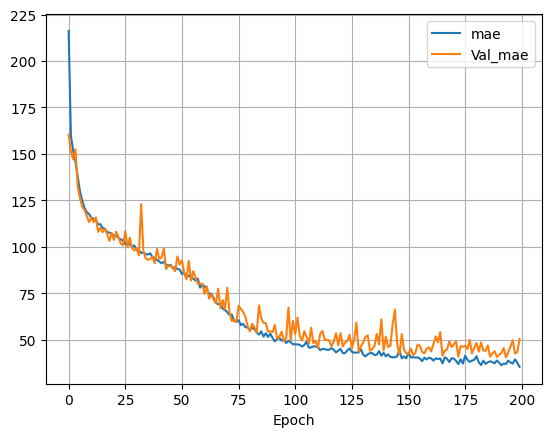

In [39]:
plot_mae(scaled_history)

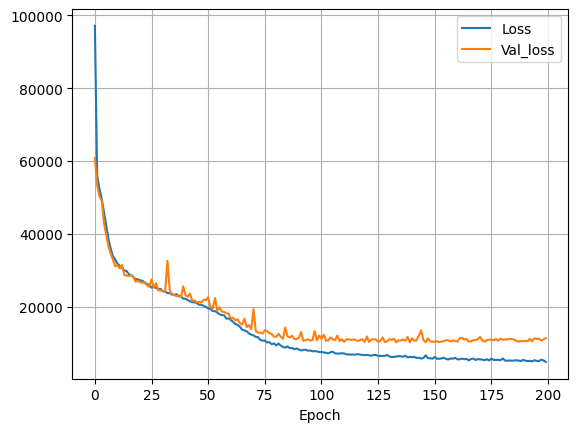

In [40]:
plot_loss(scaled_history)

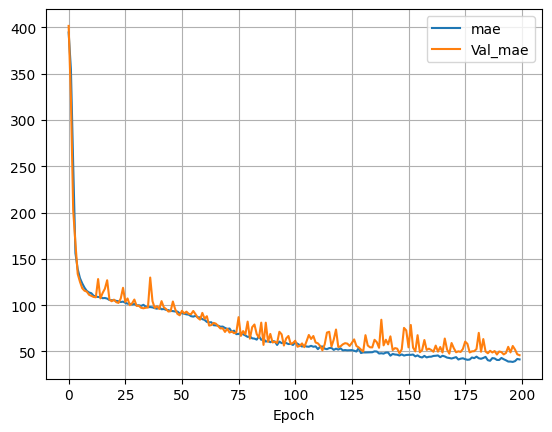

In [36]:
plot_mae(non_scaled_history)

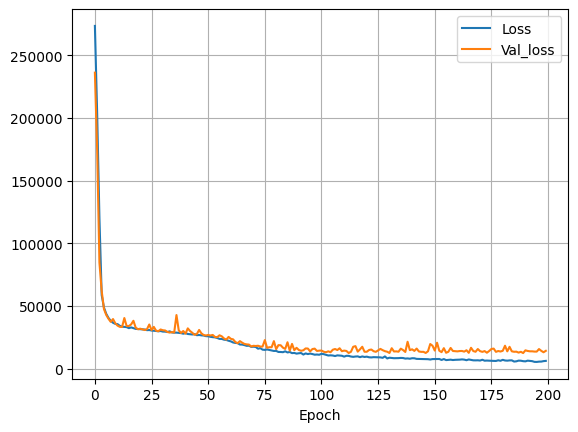

In [37]:
plot_loss(non_scaled_history)

# Zapisanie najlepszego modelu do pliku

In [38]:
best_scaled_model.save("../Models/Total_building_scaled_model.keras")
best_nonscaled_model.save("../Models/Total_building_nonscaled_model.keras")